In [1]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations_with_replacement
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%config inlinebackend.figure_format = 'svg'

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
df =pd.read_csv('set-lipstick-original/list.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [4]:
path_label = 'set-lipstick-original/mask/'
path_image = 'set-lipstick-original/720p/'

In [5]:
images = []
masks = []
for root, dirs, files in os.walk('set-lipstick-original'):
    for name in files:
        f =  name
        if 'image' in f:
            images.append(f)
        elif 'mask' in f:
            masks.append(f)
        else:
            break

In [6]:
df=df[df['mask'].isin(masks)]

In [7]:
df['filename']=df['filename'].apply(lambda x: os.path.join(path_image, x))
df['mask']=df['mask'].apply(lambda x: os.path.join(path_label, x))


In [8]:
df = pd.DataFrame({'images': df['filename'], 'masks': df['mask']})
df.drop(index=615, inplace=True)

In [9]:
labels=['others','lips']

In [10]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [12]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info,classes=1,preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
        
        # convert str names to class values on masks
        # Конвертируем стринговые имена в значения класса на маске
        self.class_values = [labels.index(cls) for cls in labels]
        self.preprocessing = preprocessing
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 1280, 720 float-значний
        img = Image.open(self.image_arr[index])
        # Преобразовываем к размеру 256х256
        img = img.resize((256,256))
        img = np.asarray(img).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # Количество каналов ставим на первый план - этого хочет pytorch
        img = img.permute(2,0,1).float()
        
        # Считываем нашу маску
#         print(plt.imread(self.label_arr[index]).shape, index)
        mask = np.asarray(plt.imread(self.label_arr[index])[:,:,1])*255
        mask = np.where(mask[:,:]>100, 1,0)

#         # Здесь мы создаем список бинарных масок из нашей одной общей маски 
        masks = [(mask == v) for v in self.class_values]
        # Стекаем все вместе в один многомерный тензор масок
        mask = np.stack(masks, axis=-1).astype('float')
        #  Приводим к типу тензора
        mask = torch.as_tensor(mask)
        # Размерность каналов на передний план
        mask = mask.permute(2,0,1)
        
        mask = mask.unsqueeze(0)
        mask = F.interpolate(input=mask, size=(256,256), mode='nearest')
        mask=mask.squeeze(0).squeeze(0)
        
        
        return (img, mask)

    def __len__(self):
        return self.data_len

In [13]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [14]:
train_data_loader = DataLoader(train_data,batch_size=8,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=2,shuffle=False)

In [24]:
sample = iter(train_data_loader).next()
sample[0].size()

torch.Size([8, 3, 256, 256])

In [15]:
import segmentation_models_pytorch as smp
import time
criterion = smp.utils.losses.DiceLoss()

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
import segmentation_models_pytorch as smp
import time

# создание модели
segmodel= smp.Unet()
segmodel = smp.Unet('resnet34', encoder_weights='imagenet', classes=2, activation='softmax').to(device)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=segmodel.parameters(), lr=0.0001),
])

train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

max_score = 0

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_smp_model.pth')
        print('Model saved!')
        
    if i == 5:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|█████████████████████████████| 4281/4281 [06:36<00:00, 10.80it/s, dice_loss - 0.002765, iou_score - 0.9977]
Model saved!

Epoch: 1
valid: 100%|████████████████████████████| 4281/4281 [06:42<00:00, 10.64it/s, dice_loss - 0.0003622, iou_score - 0.9995]
Model saved!

Epoch: 2
valid: 100%|████████████████████████████| 4281/4281 [06:56<00:00, 10.28it/s, dice_loss - 0.0003767, iou_score - 0.9993]

Epoch: 3
valid: 100%|████████████████████████████| 4281/4281 [06:47<00:00, 10.50it/s, dice_loss - 0.0002528, iou_score - 0.9996]
Model saved!

Epoch: 4
valid: 100%|████████████████████████████| 4281/4281 [06:46<00:00, 10.53it/s, dice_loss - 0.0002026, iou_score - 0.9996]
Model saved!


In [20]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

torch.Size([2, 3, 256, 256])


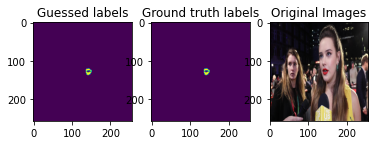

<Figure size 432x288 with 0 Axes>

torch.Size([2, 3, 256, 256])


<Figure size 432x288 with 0 Axes>

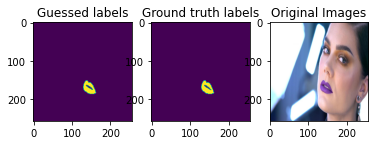

<Figure size 432x288 with 0 Axes>

torch.Size([2, 3, 256, 256])


<Figure size 432x288 with 0 Axes>

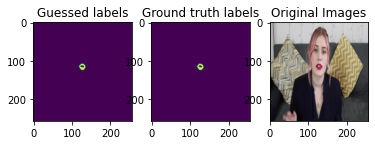

<Figure size 432x288 with 0 Axes>

torch.Size([2, 3, 256, 256])


<Figure size 432x288 with 0 Axes>

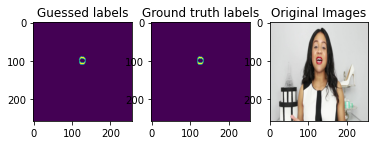

<Figure size 432x288 with 0 Axes>

torch.Size([2, 3, 256, 256])


<Figure size 432x288 with 0 Axes>

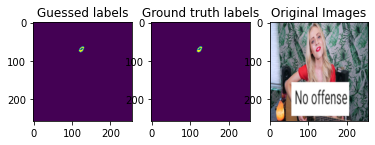

<Figure size 432x288 with 0 Axes>

torch.Size([2, 3, 256, 256])


<Figure size 432x288 with 0 Axes>

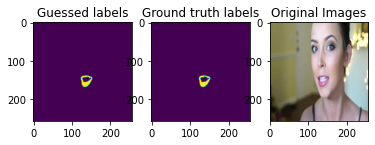

<Figure size 432x288 with 0 Axes>

torch.Size([2, 3, 256, 256])


<Figure size 432x288 with 0 Axes>

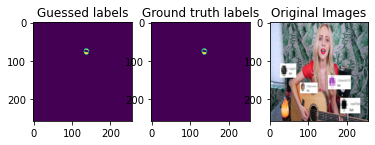

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [27]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    print(images.shape)
    outputs = segmodel.predict(images)
    f, axarr = plt.subplots(1,3)

    for j in range(0,2):
        axarr[0].imshow(outputs.detach().cpu().numpy()[j,1,:,:])
        axarr[0].set_title('Guessed labels')

        axarr[1].imshow(labels.detach().cpu().numpy()[j,1,:,:])
        axarr[1].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
        plt.gcf().show()
    if i>5:
        break